In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS 데이터 추출

In [2]:
data = pd.read_csv('./211104/211104 kpeb1.csv', parse_dates = True)

In [3]:
data

,datetime,HeatPump(W),Total_Consumption(W),Total_Production(W),Pv1_Supply(W),Pv2_Supply(W)
0,2021-06-16 13:33:00,0,0,0,0,0
1,2021-06-16 13:34:00,0,0,0,0,0
2,2021-06-16 13:35:00,0,0,0,0,0
3,2021-06-16 13:36:00,0,0,0,0,0
4,2021-06-16 13:37:00,0,0,0,0,0
...,...,...,...,...,...,...
181551,2021-11-04 16:28:00,197,8995,1797,617,1180
181552,2021-11-04 16:29:00,197,10006,1726,601,1125
181553,2021-11-04 16:30:00,195,10279,1666,585,1082
181554,2021-11-04 16:31:00,196,10606,1614,570,1044


In [4]:
all_features = data.columns.tolist()
print(all_features)

['datetime', 'HeatPump(W)', 'Total_Consumption(W)', 'Total_Production(W)', 'Pv1_Supply(W)', 'Pv2_Supply(W)']


In [5]:
df_kpeb1 = pd.DataFrame()
df_kpeb1['Time'] = data['datetime']
df_kpeb1['Cons_kpeb1(W)'] = data['Total_Consumption(W)']
df_kpeb1['Prod_kpeb1(W)'] = data['Total_Production(W)']

df_kpeb1.head()


,Time,Cons_kpeb1(W),Prod_kpeb1(W)
0,2021-06-16 13:33:00,0,0
1,2021-06-16 13:34:00,0,0
2,2021-06-16 13:35:00,0,0
3,2021-06-16 13:36:00,0,0
4,2021-06-16 13:37:00,0,0


In [6]:
df_kpeb1['Time'] = pd.to_datetime(df_kpeb1['Time'])

In [7]:
df_kpeb1=df_kpeb1[(df_kpeb1['Time']>='2021-09-13 00:00:00')]

In [8]:
df_kpeb1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66375 entries, 115181 to 181555
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           66375 non-null  datetime64[ns]
 1   Cons_kpeb1(W)  66375 non-null  int64         
 2   Prod_kpeb1(W)  66375 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.0 MB


In [9]:
df_kpeb1['Cons_kpeb1(W)'] = df_kpeb1['Cons_kpeb1(W)'].astype(float)
df_kpeb1['Prod_kpeb1(W)'] = df_kpeb1['Prod_kpeb1(W)'].astype(float)

In [10]:
df_kpeb1['Cons_acc_kpeb1(Wh)'] = df_kpeb1['Cons_kpeb1(W)'].cumsum()*60/3600
df_kpeb1['Prod_acc_kpeb1(Wh)'] = df_kpeb1['Prod_kpeb1(W)'].cumsum()*60/3600

In [11]:
df_kpeb1 = df_kpeb1[df_kpeb1['Cons_kpeb1(W)']< 35000]

In [12]:
df_kpeb1['denominator'] = df_kpeb1.loc[:,['Cons_kpeb1(W)','Prod_kpeb1(W)']].min(axis=1)
df_kpeb1['denominator_acc'] = df_kpeb1.loc[:,['Cons_acc_kpeb1(Wh)','Prod_acc_kpeb1(Wh)']].min(axis=1)

In [13]:
df_kpeb1['SCF'] = df_kpeb1['denominator']/df_kpeb1['Prod_kpeb1(W)']
df_kpeb1['LCF'] = df_kpeb1['denominator']/df_kpeb1['Cons_kpeb1(W)']

In [14]:
df_kpeb1['SCF_acc'] = df_kpeb1['denominator_acc']/df_kpeb1['Prod_acc_kpeb1(Wh)']
df_kpeb1['LCF_acc'] = df_kpeb1['denominator_acc']/df_kpeb1['Cons_acc_kpeb1(Wh)']
df_kpeb1['self_sustain'] = df_kpeb1['Prod_acc_kpeb1(Wh)']/df_kpeb1['Cons_acc_kpeb1(Wh)']
df_kpeb1['Avg_SCF&LCF'] = (df_kpeb1['SCF_acc']+df_kpeb1['LCF_acc'])/2

In [15]:
df_kpeb1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66371 entries, 115181 to 181555
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Time                66371 non-null  datetime64[ns]
 1   Cons_kpeb1(W)       66371 non-null  float64       
 2   Prod_kpeb1(W)       66371 non-null  float64       
 3   Cons_acc_kpeb1(Wh)  66371 non-null  float64       
 4   Prod_acc_kpeb1(Wh)  66371 non-null  float64       
 5   denominator         66371 non-null  float64       
 6   denominator_acc     66371 non-null  float64       
 7   SCF                 30696 non-null  float64       
 8   LCF                 66366 non-null  float64       
 9   SCF_acc             66021 non-null  float64       
 10  LCF_acc             66371 non-null  float64       
 11  self_sustain        66371 non-null  float64       
 12  Avg_SCF&LCF         66021 non-null  float64       
dtypes: datetime64[ns](1), float64(12)
memory

In [20]:
df_kpeb1

,Cons_kpeb1(W),Prod_kpeb1(W),Cons_acc_kpeb1(Wh),Prod_acc_kpeb1(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,
2021-09-13 00:00:00,5695.0,0.0,9.491667e+01,0.000000e+00,0.0,0.000000e+00,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:01:00,5284.0,0.0,1.829833e+02,0.000000e+00,0.0,0.000000e+00,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:03:00,5551.0,0.0,2.755000e+02,0.000000e+00,0.0,0.000000e+00,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:06:00,4703.0,0.0,3.538833e+02,0.000000e+00,0.0,0.000000e+00,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:11:00,5248.0,0.0,4.413500e+02,0.000000e+00,0.0,0.000000e+00,NaN,0.000000,NaN,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-04 16:28:00,8995.0,1797.0,8.674526e+06,5.592994e+06,1797.0,5.592994e+06,1.0,0.199778,1.0,0.644761,0.644761,0.822380
2021-11-04 16:29:00,10006.0,1726.0,8.674693e+06,5.593023e+06,1726.0,5.593023e+06,1.0,0.172497,1.0,0.644752,0.644752,0.822376
2021-11-04 16:30:00,10279.0,1666.0,8.674864e+06,5.593051e+06,1666.0,5.593051e+06,1.0,0.162078,1.0,0.644742,0.644742,0.822371


In [16]:
df_kpeb1.to_csv('./211105_kpeb1.csv')

# Scatter plotting

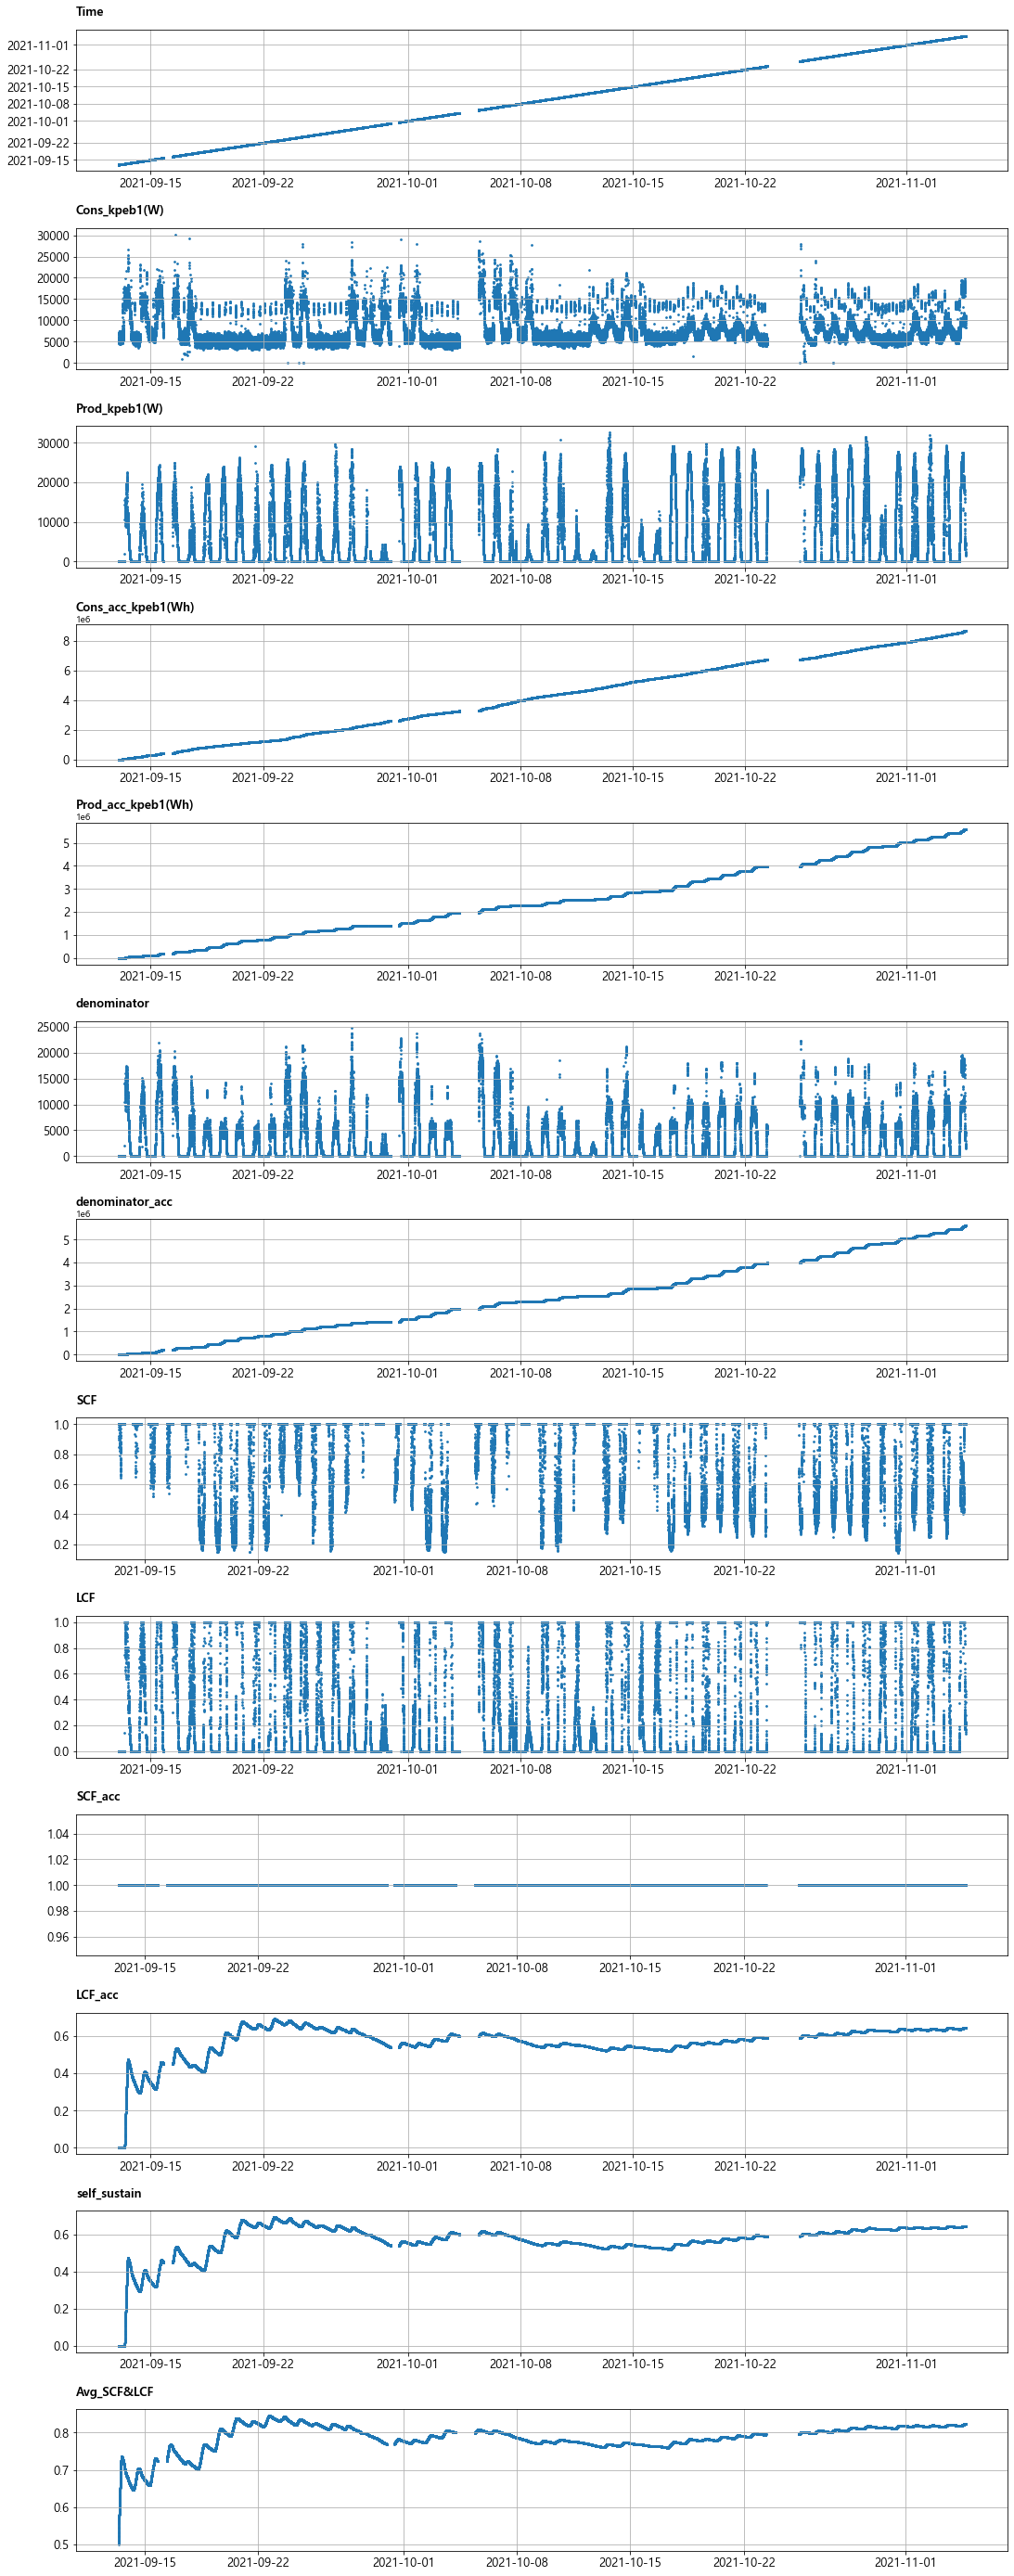

In [17]:
fig, ax = plt.subplots(figsize=(18,50))


for i in range(len(df_kpeb1.columns)):
    plt.subplot(len(df_kpeb1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
#     plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_kpeb1.columns[i]
    plt.scatter(x=df_kpeb1['Time'], y=df_kpeb1[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()

# Line plotting

In [18]:
df_kpeb1=df_kpeb1.set_index('Time')

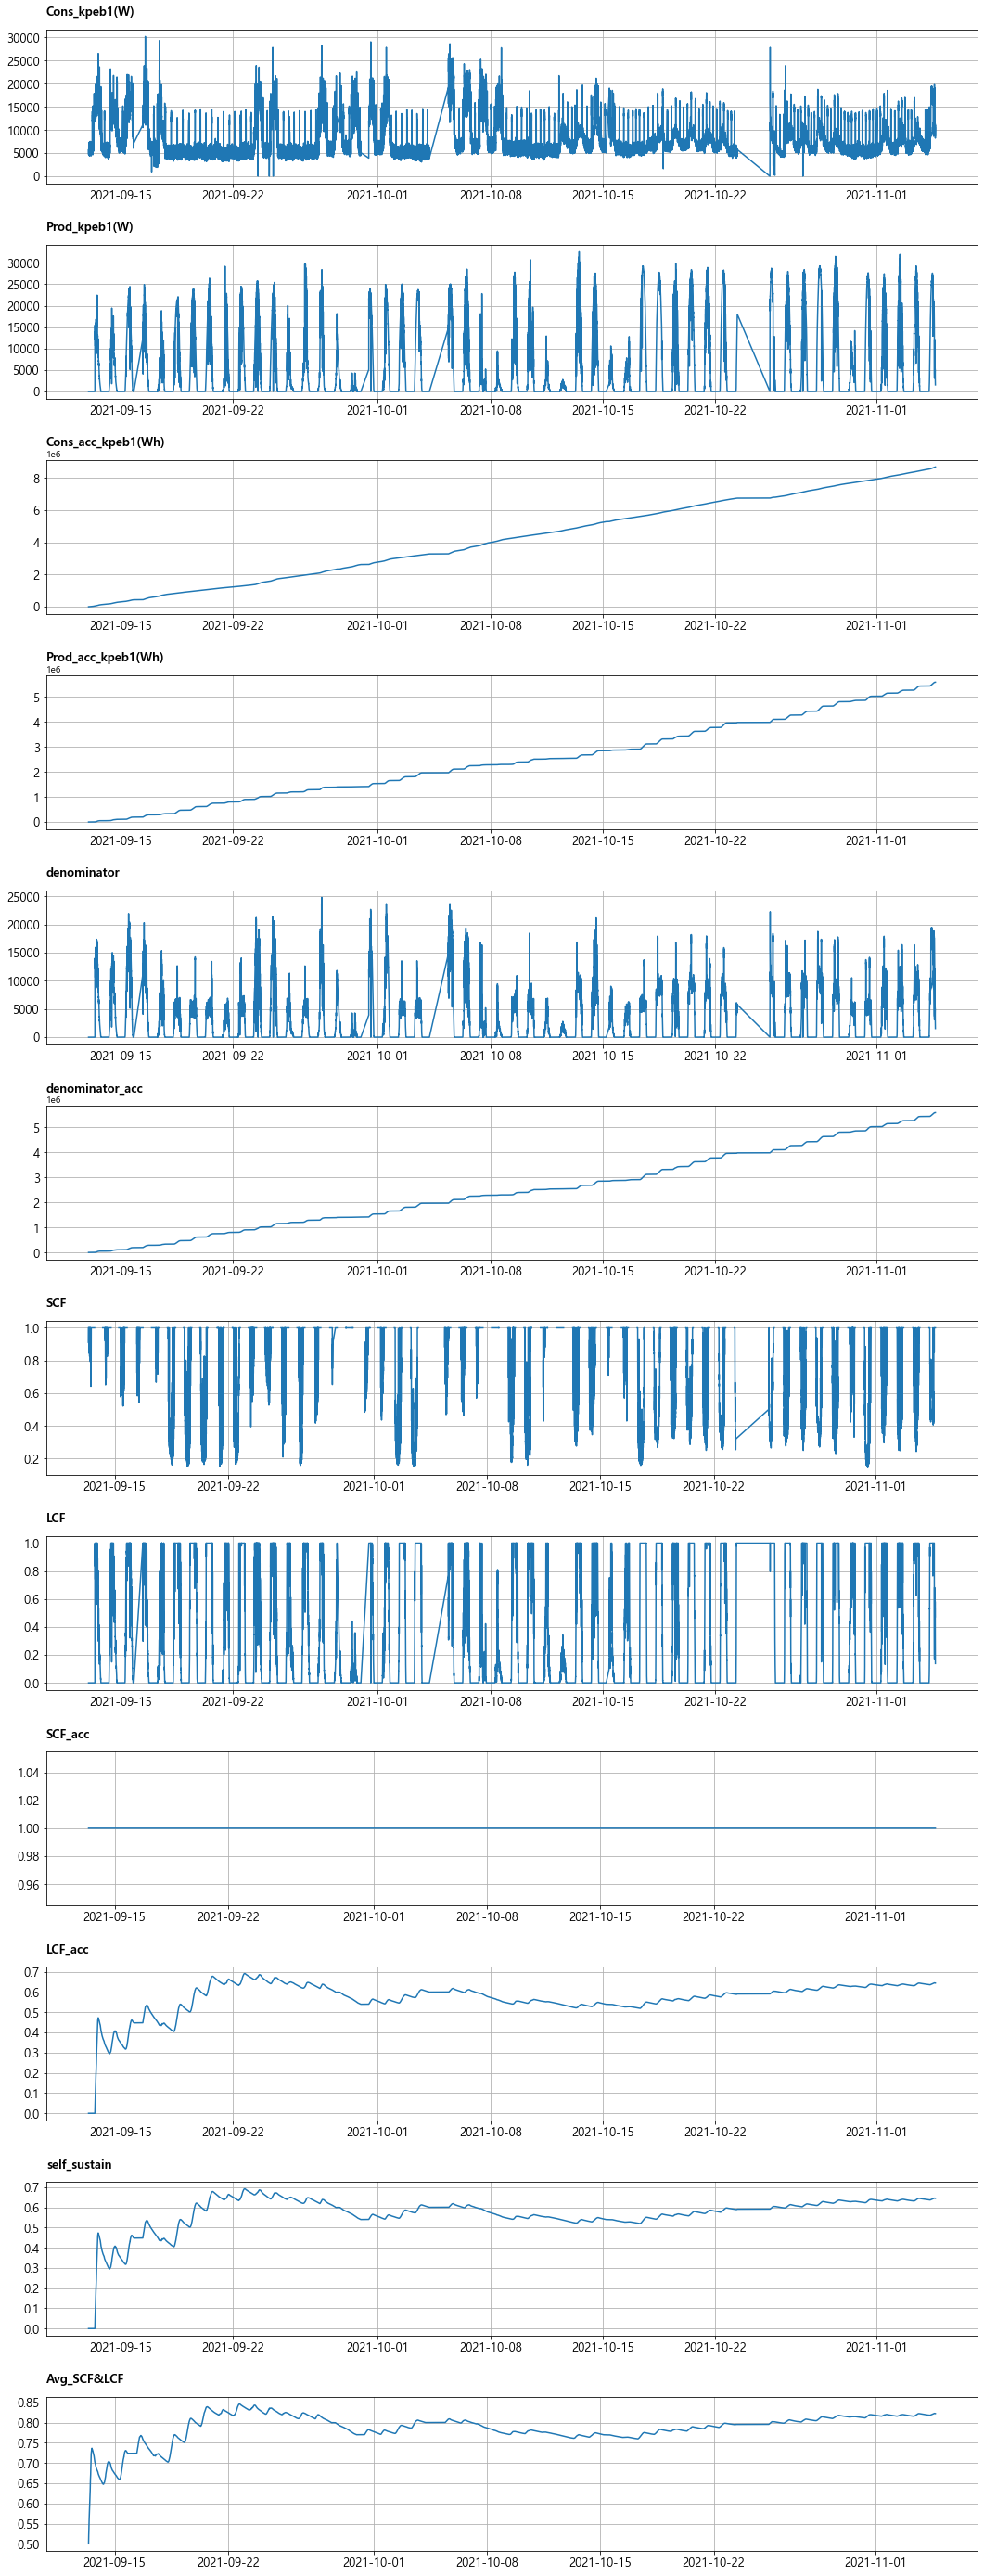

In [19]:
fig, ax = plt.subplots(figsize=(18,50))

for i in range(len(df_kpeb1.columns)):
    plt.subplot(len(df_kpeb1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpeb1.columns[i]
    plt.plot(df_kpeb1[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
#     plt.xlim(pd.Timestamp('2020-11-01'), pd.Timestamp('2021-08-31'))    
    plt.grid(True)
plt.show()
fig.tight_layout()